In [1]:
import numpy as np
import pandas as pd
import root_pandas
import root_numpy

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from itertools import islice

from tqdm import tqdm

import ROOT

from scripts.data_preparation import get_single_tagging_particles, concat_df_chunks

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)

# Read in Data from `/net/storage`

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
chunksize = 1000

In [4]:
data_kwargs = dict(
    key='DecayTree',
    columns=['B_OS_Muon*', 'B_*', 'SigYield_sw', 'BkgYield_sw'],
    ignore=['B_ENDVERTEX_COV_',
         'B_OWNPV_COV_',
         'B_TOPPV_COV_',
         'B_OS_E*',
         'B_OS_K*',
         'B_All*',
         'B_Hlt*',
         'B_L0*',
        ],
    chunksize=chunksize,
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',
    flatten=True
)

In [5]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [6]:
full_data = get_single_tagging_particles(concat_df_chunks(filenames, **data_kwargs),
                                         lambda x: np.sign(x.B_ID) == np.sign(x.B_OS_Muon_ID),
                                         chunksize=chunksize,
                                         n_entries=n_entries)

851it [25:28,  1.92s/it]                             


In [7]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

all_muon_features = [c for c in full_data.columns if c.startswith('B_OS_Muon')] + ['B_PT']

In [81]:
classic_data = full_data[all_muon_features + ['target', 'SigYield_sw', 'B_ID']].copy(deep=True)
labels = full_data.target

In [82]:
classic_data.describe()

/home/kheinicke/.local/lib/python3.4/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,B_OS_Muon_DEC,B_OS_Muon_PROB,B_OS_Muon_PARTICLES_NUM,B_OS_Muon_ABSID,B_OS_Muon_P,B_OS_Muon_PT,B_OS_Muon_TRCHI2DOF,B_OS_Muon_BPVIPCHI2(),B_OS_Muon_TRTYPE,B_OS_Muon_PIDmu,...,B_OS_Muon_RecVertexIP,B_OS_Muon_countTracks,B_OS_Muon_Signal_PT,B_OS_Muon_ABS_RecVertexIP,B_OS_Muon_KEY,B_OS_Muon_Q,B_OS_Muon_ID,B_PT,SigYield_sw,B_ID
count,850118.000000,850118.000000,850118.000000,850118.000000,850118.000000,850118.000000,850118.000000,8.501180e+05,850118.000000,850118.000000,...,850099.000000,850118.000000,850118.000000,850099.000000,850118.000000,850118.00000,850118.000000,850118.000000,850118.000000,850118.000000
mean,0.000345,0.496480,64.271427,146.847610,52293.898438,4101.879883,1.131399,3.056343e+03,3.017532,1.131250,...,14.713865,43.497963,5921.060547,46.422390,9.209163,0.01010,2.513853,5921.059986,0.863612,7.748952
std,0.143889,0.024207,31.944860,136.832153,37802.238281,1735.600708,0.425023,5.459842e+04,0.131242,5.203615,...,133.793289,19.578403,4382.253906,126.341217,17.657362,0.99995,200.701172,4382.253771,0.593945,520.942677
min,-1.000000,0.330000,5.000000,11.000000,3116.070068,993.622803,0.044473,1.112766e-06,3.000000,-63.141289,...,-3673.509521,3.000000,10.540826,0.001672,0.000000,-1.00000,-321.000000,10.540825,-1.553546,-521.000000
25%,0.000000,0.500000,41.000000,13.000000,24336.872070,2811.012573,0.843413,8.018691e+00,3.000000,-3.413238,...,NaN,29.000000,2903.170410,NaN,1.000000,-1.00000,-211.000000,2903.170362,0.946708,-521.000000
50%,0.000000,0.500000,59.000000,211.000000,41026.539062,3640.716675,1.049978,9.448277e+01,3.000000,0.642878,...,NaN,41.000000,4880.545898,NaN,3.000000,1.00000,11.000000,4880.546061,1.116237,521.000000
75%,0.000000,0.500000,81.000000,321.000000,68836.941406,4956.410034,1.317640,5.415041e+02,3.000000,6.037613,...,NaN,55.000000,7703.988525,NaN,8.000000,1.00000,211.000000,7703.988668,1.150646,521.000000
max,1.000000,0.500000,402.000000,321.000000,199995.203125,9999.997070,2.999958,1.349467e+07,4.000000,14.679550,...,3720.085449,205.000000,83415.429688,3720.085449,364.000000,1.00000,321.000000,83415.432590,1.172890,521.000000


In [83]:
classic_data.replace([np.inf], 10000, inplace=True)
classic_data.dropna(inplace=True)

# Apply Muon Selections

In [84]:
classic_data = classic_data[
    (classic_data.B_OS_Muon_P > 0)
    & (classic_data.B_OS_Muon_PT > 500)
    & (classic_data.B_OS_Muon_IsSignalDaughter == 0)
#    & (classic_data.B_OS_Muon_phiDistance > 0.005)
    & (classic_data.B_OS_Muon_MuonPIDIsMuon == 1)
    & (classic_data.B_OS_Muon_TRCHI2DOF < 3)
    & (classic_data['B_OS_Muon_BPVIPCHI2()'] > 0)
    & (classic_data.B_OS_Muon_RecVertexIP > 0)
    & (classic_data.B_OS_Muon_TRGHP < 0.4)
    & (classic_data.B_OS_Muon_PROBNNmu > 0.35)
    & (classic_data.B_OS_Muon_PROBNNpi < 0.8)
    & (classic_data.B_OS_Muon_PROBNNe < 0.8)
    & (classic_data.B_OS_Muon_PROBNNk < 0.8)
    & (classic_data.B_OS_Muon_PROBNNp < 0.8)
    & (classic_data.SigYield_sw > 0)
]
labels = classic_data.target

In [85]:
classic_data.shape

(4507, 34)

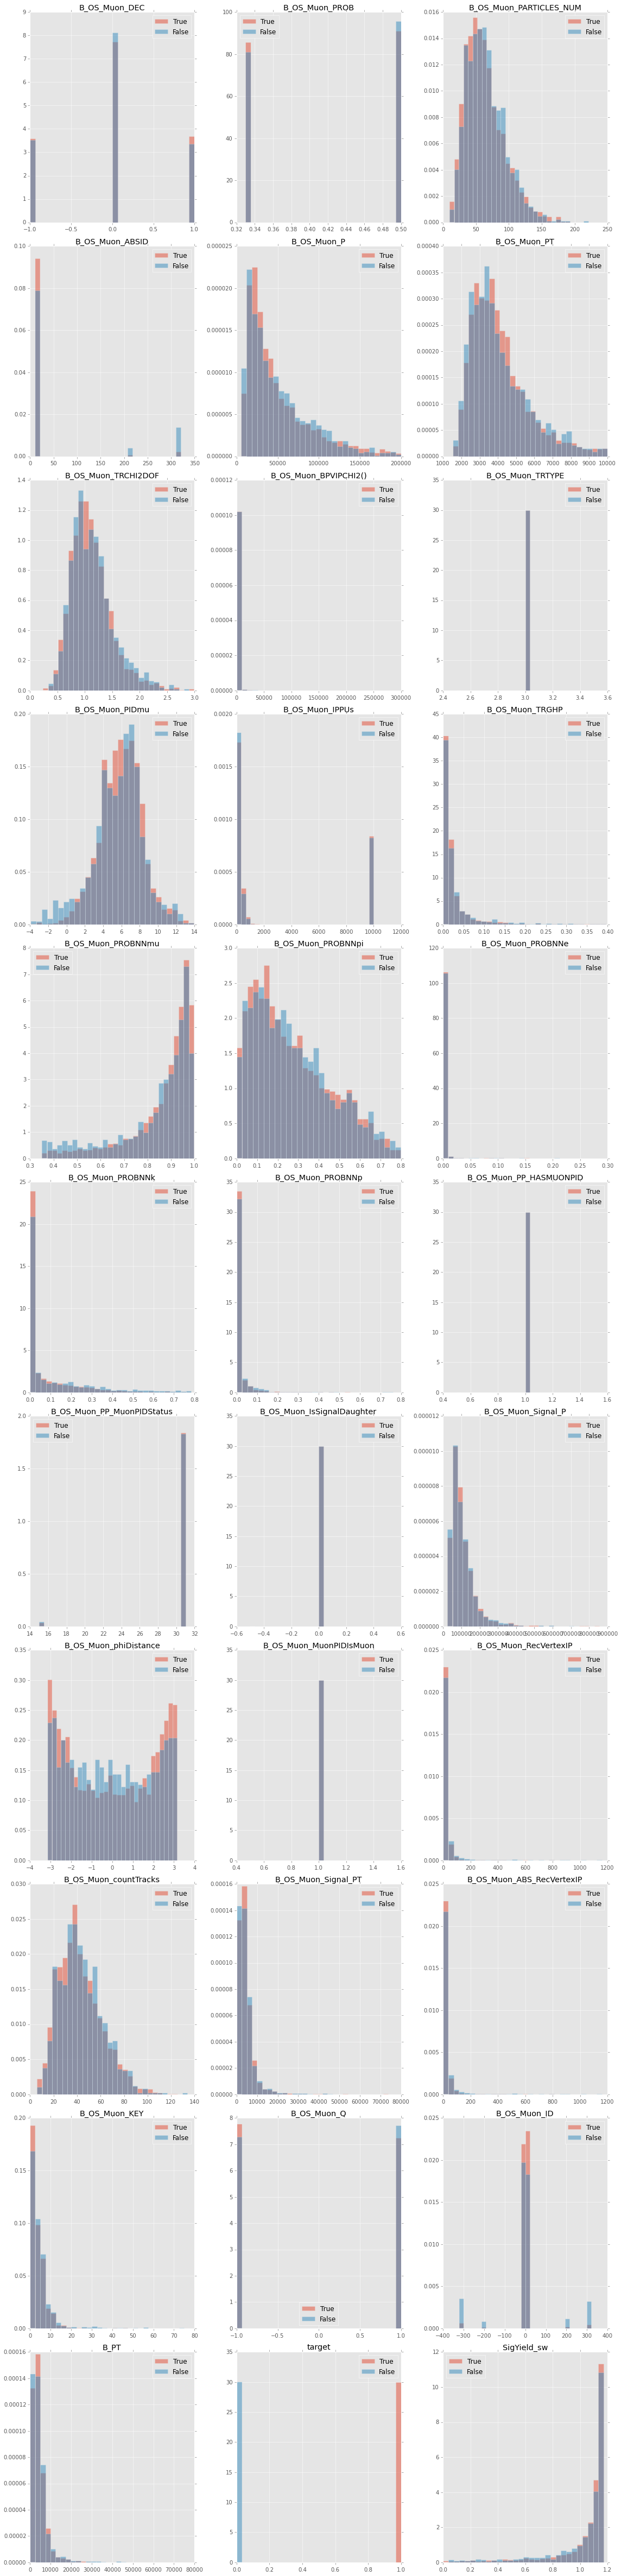

In [56]:
ncols = 3
nrows = np.ceil(len(classic_data.columns)/ncols)
plt.figure(figsize=(16, nrows * 6))
for i, f in enumerate(classic_data.columns):
    plt.subplot(nrows, ncols, i+1)
    _, bins = np.histogram(classic_data[f], 30)
    classic_data[labels==True][f].hist(bins=bins, alpha=0.5, label='True', normed=True)
    classic_data[labels==False][f].hist(bins=bins, alpha=0.5, label='False', normed=True)
    plt.title(f[:32])
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [119]:
train_data, test_data, train_labels, test_labels = train_test_split(classic_data, labels, test_size=0.3)

In [120]:
gbm = xgb.XGBClassifier(max_depth=6, silent=False)

In [121]:
gbm.fit(train_data[classic_MVA_features], train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [123]:
probas = gbm.predict_proba(test_data[classic_MVA_features])[:,1]
preds = gbm.predict(test_data[classic_MVA_features])
score = roc_auc_score(test_labels, probas)

In [125]:
gb = GradientBoostingClassifier()
gb.fit(train_data[classic_MVA_features], train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [126]:
gb_probas = gb.predict_proba(test_data[classic_MVA_features])[:,1]
gb_score = roc_auc_score(test_labels, gb_probas)

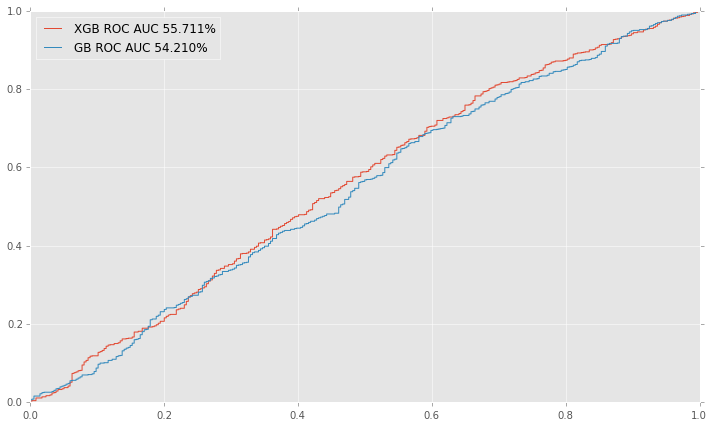

In [127]:
plt.plot(*roc_curve(test_labels, gb_probas)[:2], label='XGB ROC AUC {:2.3f}%'.format(gb_score * 100))
plt.plot(*roc_curve(test_labels, probas)[:2], label='GB ROC AUC {:2.3f}%'.format(score * 100))
plt.legend(loc='best')
plt.show()

In [128]:
from scripts.utils import compute_mistag

In [130]:
compute_mistag(probas, np.sign(test_data.B_ID), test_data.SigYield_sw, np.ones(len(test_data)).astype('bool'))

ValueError: object of too small depth for desired array